In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
import numpy as np
import pandas as pd
from kcsd import KCSD1D

In [4]:
from sglxarray import load_trigger
from ecephys.signal.utils import mean_subtract
from ecephys.xrsig import get_kcsd
import ecephys_analyses as ea

In [5]:
def mm_to_mask(lo, hi, ele_pos):
    assert lo < hi, "Lower bound must be less than upper bound."     
    return np.logical_and(ele_pos >= lo, ele_pos <= hi).flatten()

def mm_to_idx(lo, hi, ele_pos):
    idx = np.where(millimeters_to_mask(lo, hi, ele_pos))[0]
    return idx

def mm_to_chans(lo, hi, ele_pos, chans):
    return chans[mm_to_mask(lo, hi, ele_pos)]

In [6]:
SUBJECT = "Segundo"
EXPERIMENT = "novel_objects_deprivation"
CONDITION = "recovery-sleep"
START_TIME = 1680 # pick a 1 second window that has SPW-Rs

In [7]:
SUBJECT = "Segundo"
EXPERIMENT = "isoflurane"
CONDITION = "all"
START_TIME = 2 # pick a 1 second window that has SPW-Rs

In [8]:
SUBJECT = "Valentino"
EXPERIMENT = "novel_objects_deprivation"
CONDITION = "recovery-sleep"
START_TIME = 3880 # pick a 1 second window that has SPW-Rs

In [9]:
SUBJECT = "Valentino"
EXPERIMENT = "sevo-dex"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 355 # pick a 1 second window that has SPW-Rs

In [10]:
# During Dex-induced theta, in 2-25-2020_g0_t1

SUBJECT = "Valentino"
EXPERIMENT = "sevo-dex"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 2986 # pick a 1 second window that has SPW-Rs

In [11]:
SUBJECT = "Valentino"
EXPERIMENT = "atropine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 828 # pick a 1 second window that has SPW-Rs

In [12]:
SUBJECT = "Valentino"
EXPERIMENT = "isoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 83 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.8
hpc_hi = 6.1
wm_center = 6.12
wm_thickness = 0.133

In [13]:
SUBJECT = "Valentino"
EXPERIMENT = "sevoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 77 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.866
hpc_hi = 6.166
wm_center = 6.36
wm_thickness = 0.133

In [14]:
SUBJECT = "Valentino"
EXPERIMENT = "ketamine-90mg"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 16 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.856
hpc_hi = 6.156
wm_center = 6.28
wm_thickness = 0.133

In [15]:
SUBJECT = "Doppio"
EXPERIMENT = "novel_objects_deprivation"
CONDITION = "recovery-sleep"
START_TIME = 1708 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.3
hpc_hi = 5.066
wm_center = 5.2
wm_thickness = 0.133

In [16]:
SUBJECT = "Doppio"
EXPERIMENT = "isoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 77 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.8
hpc_hi = 5.8
wm_center = 5.9
wm_thickness = 0.133

In [17]:
SUBJECT = "Doppio"
EXPERIMENT = "sevoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 202 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.8
hpc_hi = 6.0
wm_center = 5.94
wm_thickness = 0.133

In [18]:
SUBJECT = "Doppio"
EXPERIMENT = "atropine-50mg"
CONDITION = "all"
START_TIME = 1159 # pick a 1 second window that has SPW-Rs

In [19]:
SUBJECT = "Doppio"
EXPERIMENT = "ketamine-120mg"
CONDITION = "all"
PROBE = "imec1"
START_TIME = 14 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.3
hpc_hi = 5.066
wm_center = 5.2
wm_thickness = 0.133

In [20]:
SUBJECT = "Alessandro"
EXPERIMENT = "novel_objects_deprivation"
CONDITION = "recovery-sleep"
START_TIME = 1766 # pick a 1 second window that has SPW-Rs

In [21]:
SUBJECT = "Alessandro"
EXPERIMENT = "dexmedetomidine-eStim"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 2008 # pick a 1 second window that has SPW-Rs

hpc_lo = 4.0
hpc_hi = 6.05
wm_center = 6.15
wm_thickness = 0.1

In [22]:
SUBJECT = "Eugene"
EXPERIMENT = "novel_objects_deprivation"
CONDITION = "recovery-sleep"
START_TIME = 2600 # pick a 1 second window that has SPW-Rs

In [23]:
SUBJECT = "Allan"
EXPERIMENT = "novel_objects_deprivation"
CONDITION = "recovery-sleep"
START_TIME = 2007 # pick a 1 second window that has SPW-Rs

In [24]:
SUBJECT = "Allan"
EXPERIMENT = "dexmedetomidine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 3 # pick a 1 second window that has SPW-Rs

In [25]:
SUBJECT = "Allan"
EXPERIMENT = "atropine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 35 # pick a 1 second window that has SPW-Rs

In [26]:
SUBJECT = "Allan"
EXPERIMENT = "ketamine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 1791 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.2
hpc_hi = 5.4
wm_center = 5.48
wm_thickness = 0.133

In [27]:
SUBJECT = "Luigi"
EXPERIMENT = "novel_objects_deprivation"
CONDITION = "recovery-sleep"
PROBE = "imec0"
START_TIME = 410 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.5
hpc_hi = 5.6
wm_center = 5.7
wm_thickness = 0.133

In [28]:
SUBJECT = "Luigi"
EXPERIMENT = "dexmedetomidine"
CONDITION = "baseline"
PROBE = "imec0"
START_TIME = 2 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.55
hpc_hi = 5.25
wm_center = 5.35
wm_thickness = 0.1

In [30]:
SUBJECT = "Charles"
EXPERIMENT = "dexmedetomidine"
CONDITION = "baseline"
PROBE = "imec1"
START_TIME = 14 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.7
hpc_hi = 5.6
wm_center = 5.72
wm_thickness = 0.1

In [31]:
SUBJECT = "Adrian"
EXPERIMENT = "conveyor_over_water"
ALIAS = "recovery_sleep"
PROBE = "imec1"
START_TIME = 550 # pick a 1 second window that has SPW-Rs

hpc_lo = 4.22
hpc_hi = 6.26
wm_center = 6.4
wm_thickness = 0.133

In [32]:
SUBJECT = "Adrian"
EXPERIMENT = "novel_objects_deprivation"
ALIAS = "recovery_sleep"
PROBE = "imec1"
START_TIME = 4 # pick a 1 second window that has SPW-Rs

hpc_lo = 4.22
hpc_hi = 6.26
wm_center = 6.4
wm_thickness = 0.133

In [58]:
SUBJECT = "Charles"
EXPERIMENT = "novel_objects_deprivation"
ALIAS = "recovery_sleep"
PROBE = "imec1"
START_TIME = 1185 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.95
hpc_hi = 5.8
wm_center = 5.9
wm_thickness = 0.1

In [45]:
SUBJECT = "Santiago"
EXPERIMENT = "novel_objects_deprivation"
ALIAS = "recovery_sleep"
PROBE = "imec1"
START_TIME = 194 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.46
hpc_hi = 5.72
wm_center = 5.82
wm_thickness = 0.1

## 1D kCSD on whole probe

In [46]:
chans = ea.get_channels(SUBJECT, EXPERIMENT, PROBE, "all")

In [47]:
bin_path = ea.get_lfp_bin_paths(SUBJECT, EXPERIMENT, alias=ALIAS, probe=PROBE)[0]
#bin_path = ea.get_sglx_style_datapaths(subject=SUBJECT, experiment=EXPERIMENT, condition=CONDITION, ext="lf.bin")[0]

In [48]:
sig = load_trigger(bin_path, chans, start_time=(START_TIME), end_time=(START_TIME + 1.0))
sig.values = mean_subtract(sig.values)

nChan: 385, nFileSamp: 18000038


In [49]:
electrode_pitch = 0.020
ele_pos = np.arange(0, len(sig.channel)) * electrode_pitch
csd = get_kcsd(
    sig, ele_pos, gdx=electrode_pitch, do_lcurve=True
)

Performing L-curve parameter estimation...
No lambda given, using defaults
min lambda 1e-09
max lambda 0.0043
min lambda 1e-09
max lambda 0.0043
l-curve (all lambda):  0.23
Best lambda and R =  0.0018628719929130466 ,  0.23


In [50]:
print(f"Hippocampus: {hpc_lo}mm, {hpc_hi}mm")
hpc_chans = csd.sel(pos=slice(hpc_lo, hpc_hi)).channel.values # These are the channel numbers belonging to the hippocampus
print(f"Channels:\n {hpc_chans}")
print("")

wm_lo = wm_center - wm_thickness
wm_hi = wm_center + wm_thickness
print(f"White matter: {wm_lo}mm, {wm_hi}mm")
wm_chans = csd.sel(pos=slice(wm_lo, wm_hi)).channel.values # These are the channel numbers belonging to the hippocampus
print(f"Channels:\n {wm_chans}")

Hippocampus: 3.46mm, 5.72mm
Channels:
 [346 348 350 352 354 356 358 360 362 364 366 368 370 372 374 376 378 380
 382   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33
  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69
  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105
 107 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141
 143 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177
 179 181 183 185 187 189]

White matter: 5.720000000000001mm, 5.92mm
Channels:
 [191 193 195 197 199 201 203 205 207 209]


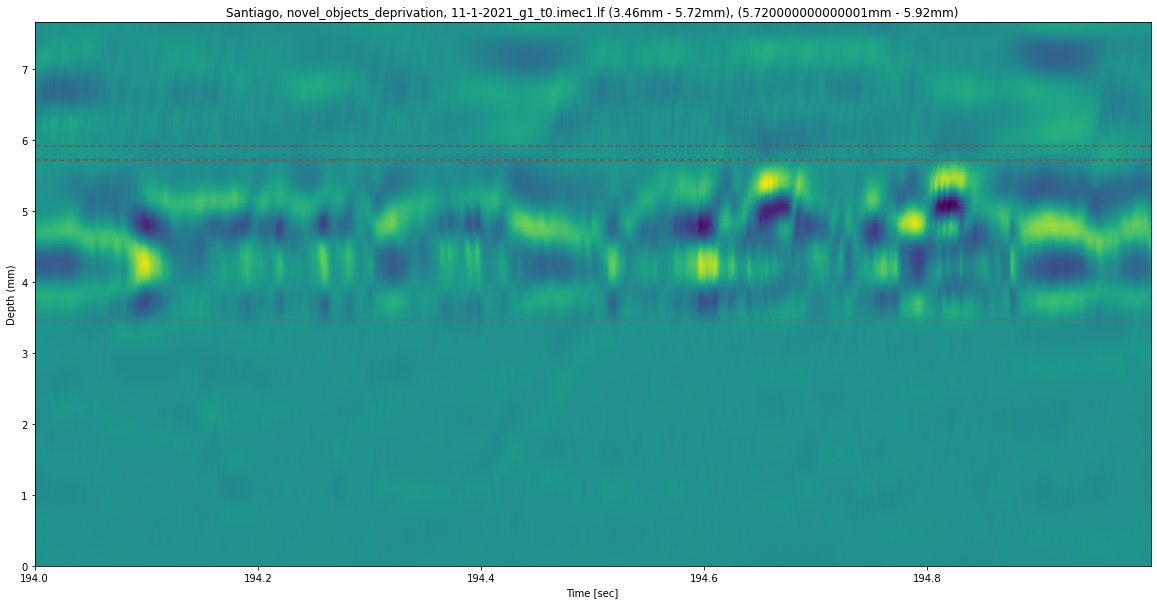

In [51]:
_, ax = plt.subplots(figsize=(20, 10))
ax.pcolormesh(csd.time.values, csd.kcsd.estm_x, csd.values, shading="gouraud")
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Depth (mm)")
ax.set_title(f"{SUBJECT}, {EXPERIMENT}, {bin_path.stem} ({hpc_lo}mm - {hpc_hi}mm), ({wm_lo}mm - {wm_hi}mm)")
ax.axhline(hpc_hi, alpha=0.5, color='dimgrey', linestyle="--")
ax.axhline(hpc_lo, alpha=0.5, color='dimgrey', linestyle="--")
ax.axhline(wm_hi, alpha=0.5, color='brown', linestyle="--")
ax.axhline(wm_lo, alpha=0.5, color='brown', linestyle="--")

In [52]:
hpc_chans

array([346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370,
       372, 374, 376, 378, 380, 382,   1,   3,   5,   7,   9,  11,  13,
        15,  17,  19,  21,  23,  25,  27,  29,  31,  33,  35,  37,  39,
        41,  43,  45,  47,  49,  51,  53,  55,  57,  59,  61,  63,  65,
        67,  69,  71,  73,  75,  77,  79,  81,  83,  85,  87,  89,  91,
        93,  95,  97,  99, 101, 103, 105, 107, 109, 111, 113, 115, 117,
       119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143,
       145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169,
       171, 173, 175, 177, 179, 181, 183, 185, 187, 189])

In [53]:
print(f"Drift tracking: {hpc_lo - 0.1}mm, {hpc_hi + 0.1}mm")
tracking_chans = csd.sel(pos=slice(hpc_lo - 0.1, hpc_hi + 0.1)).channel.values # These are the channel numbers belonging to the hippocampus
print(f"Channels:")
tracking_chans

Drift tracking: 3.36mm, 5.819999999999999mm
Channels:


array([336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360,
       362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382,   1,   3,
         5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,  27,  29,
        31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,  53,  55,
        57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,  79,  81,
        83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103, 105, 107,
       109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133,
       135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159,
       161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185,
       187, 189, 191, 193, 195, 197])

In [54]:
from ecephys.plot.plot import _lfp_explorer

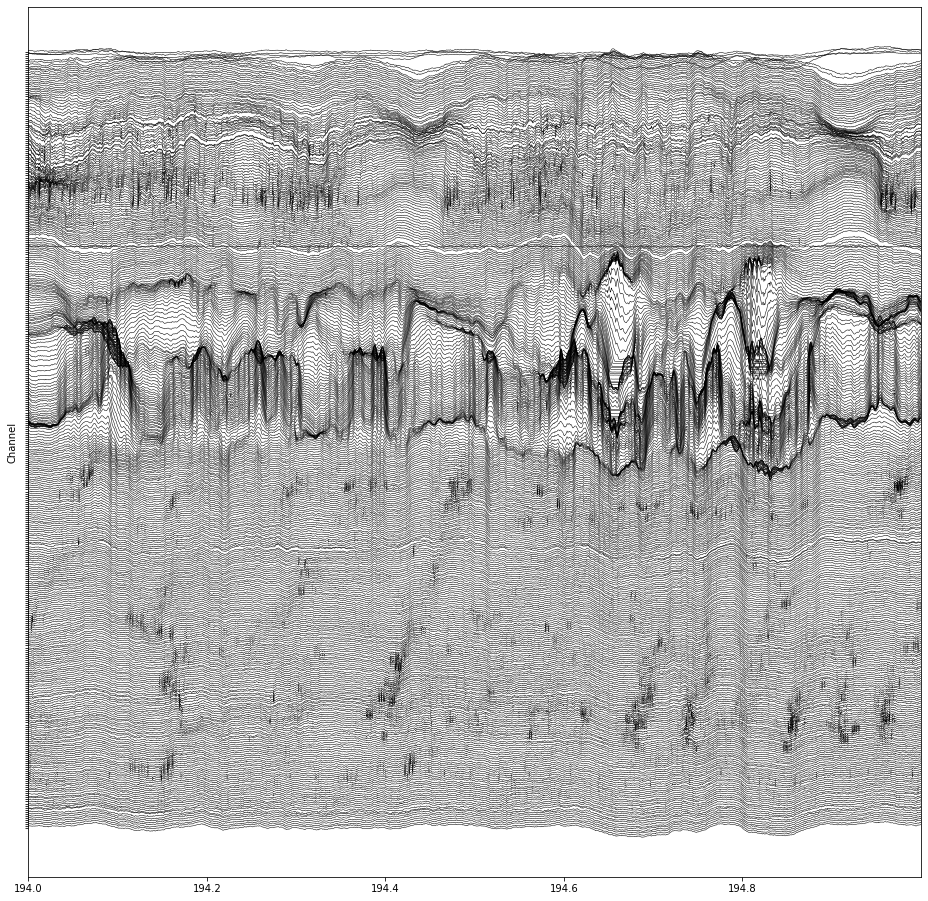

In [55]:
fig, ax = plt.subplots(figsize=(16, 16))

_lfp_explorer(sig.time.values, sig.values, ax, chan_labels=['']*384, window_length=1.0, window_start=0.0, n_plot_chans=384, i_chan=0, vspace=80, zero_mean=True, flip_dv=True)

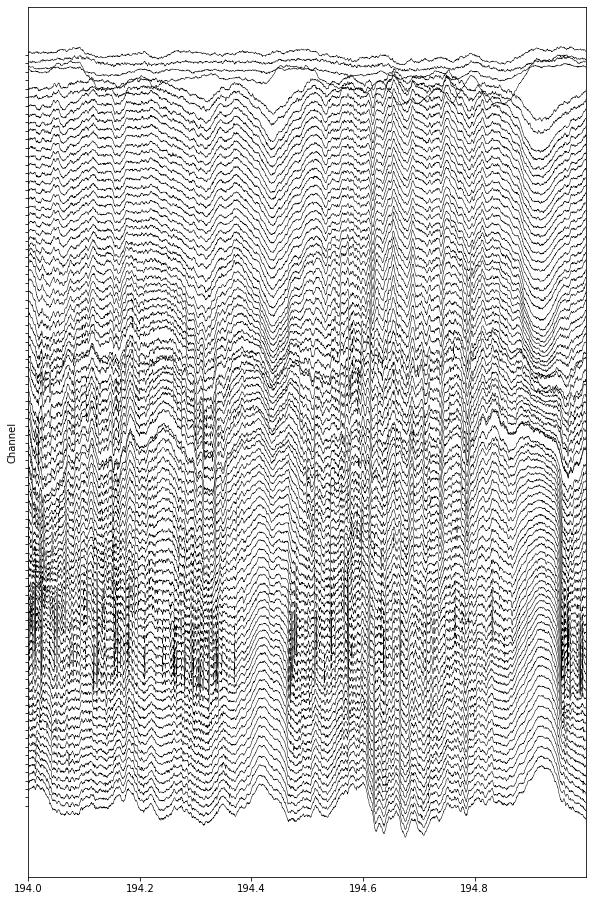

In [56]:
fig, ax = plt.subplots(figsize=(10, 16))

n_cx = 90
_lfp_explorer(sig.time.values, sig.values[:, -n_cx:], ax, chan_labels=['']*n_cx, window_length=1.0, window_start=0.0, n_plot_chans=n_cx, i_chan=0, vspace=150, zero_mean=True, flip_dv=True)